In [1]:
import bioframe as bf
import click
import pandas as pd
import time
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

In [2]:
GENE = "MYC"
CHROM_NUM = "chr8"
CRISPR_FILENAME = "/oak/stanford/groups/engreitz/Projects/Benchmarking/CRISPR_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz"
fragment_file = "/oak/stanford/groups/engreitz/Users/atan5133/data/scATAC/xu_et_al_chrx_fragments.tsv"
TSS_FILE = "/oak/stanford/groups/engreitz/Users/atan5133/ABC-Enhancer-Gene-Prediction/reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed"

In [3]:
def does_overlap(start1, end1, start2, end2):
    if end1 <= start2 or end2 <= start1:
        return False
    else:
        return True

def find_region_idx(candidate_regions_df, coord):
    matching_elements = [idx for idx, row in candidate_regions_df.iterrows() if does_overlap(row["start"], row["end"], coord[0], coord[1])]
    if matching_elements:
        return matching_elements[0]
    raise Exception(f"Cannot find {coord} in enhancer list")

def get_crispr_record(region_idx, enh_df, enh_crispr_df):
    return enh_crispr_df[enh_crispr_df["start"] == enh_df.loc[region_idx, "start"]].iloc[0]

In [4]:
tss_df = pd.read_csv(TSS_FILE, sep="\t")
tss_df = tss_df.rename(columns={"#chr": "chrom"})
promoter_TSS = tss_df[tss_df["name"] == GENE].iloc[0][["start", "end"]].values

In [5]:
tss_df[tss_df["name"] == GENE].iloc[0]

chrom                    chr8
start               127735818
end                 127736318
name                      MYC
score                       0
strand                      +
Ensembl_ID    ENSG00000136997
gene_type      protein_coding
Name: 8932, dtype: object

In [6]:
crispr_df = pd.read_csv(CRISPR_FILENAME, sep="\t").rename(columns={"chromStart": "start", "chromEnd": "end"})
crispr_df = crispr_df[crispr_df['measuredGeneSymbol'] == GENE].reset_index(drop=True)


# enh_tss_df = bf.overlap(enh_df, tss_df, how='inner', return_index=True)
# promoter_indexes = list(enh_tss_df["index"])

In [7]:
crispr_df[crispr_df['Regulated']]

,dataset,chrom,start,end,name,EffectSize,chrTSS,startTSS,endTSS,measuredGeneSymbol,...,Reference,Regulated,PowerAtEffectSize10,PowerAtEffectSize15,PowerAtEffectSize20,PowerAtEffectSize50,pair_uid,merged_uid,merged_start,merged_end
19,FlowFISH_K562,chr8,127898896,127898963,MYC|chr8:128911142-128911209:*,-0.358840,chr8,127735434.0,127735435.0,MYC,...,Fulco2019,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:128911142-128911209:*,9250,127898896,127898963
25,FlowFISH_K562,chr8,127957679,127960199,MYC|chr8:128969925-128972445:*,-0.084605,chr8,127735434.0,127735435.0,MYC,...,Fulco2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:128969925-128972445:*,9256,127957679,127960199
26,FlowFISH_K562,chr8,127960391,127960502,MYC|chr8:128972637-128972748:*,-0.635930,chr8,127735434.0,127735435.0,MYC,...,Fulco2019,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:128972637-128972748:*,9257,127960391,127960502
27,FlowFISH_K562,chr8,127961319,127963819,MYC|chr8:128973565-128976065:*,-0.113047,chr8,127735434.0,127735435.0,MYC,...,Fulco2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:128973565-128976065:*,9258,127961319,127963819
89,FlowFISH_K562,chr8,129581780,129582461,MYC|chr8:130594026-130594707:*,-0.190130,chr8,127735434.0,127735435.0,MYC,...,Fulco2019,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:130594026-130594707:*,9320,129581780,129582461
97,FlowFISH_K562,chr8,129689360,129689694,MYC|chr8:130701606-130701940:*,-0.251250,chr8,127735434.0,127735435.0,MYC,...,Fulco2019,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:130701606-130701940:*,9328,129689360,129689694
98,FlowFISH_K562,chr8,129689879,129692379,MYC|chr8:130702125-130704625:*,-0.092625,chr8,127735434.0,127735435.0,MYC,...,Fulco2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:130702125-130704625:*,9329,129689879,129692379
99,FlowFISH_K562,chr8,129692458,129693217,MYC|chr8:130704704-130705463:*,-0.223050,chr8,127735434.0,127735435.0,MYC,...,Fulco2019,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:130704704-130705463:*,9330,129692458,129693217
100,FlowFISH_K562,chr8,129696899,129699399,MYC|chr8:130709145-130711645:*,-0.047932,chr8,127735434.0,127735435.0,MYC,...,Fulco2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|MYC|chr8:130709145-130711645:*,9331,129693639,129699399


In [8]:
# # Experimental

# ATAC_ENH_FILENAME = '/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_10_26_dev_atac_k562_hic/Neighborhoods/EnhancerList.txt'
# atac_enh_df = pd.read_csv(ATAC_ENH_FILENAME, sep='\t').rename(columns={"chr": "chrom"})
# atac_enh_df = atac_enh_df[(atac_enh_df["chrom"] == CHROM_NUM)].reset_index(drop=True)
# crispr_enhancers = atac_enh_df[["chrom", "start", "end", "name"]]

In [9]:
crispr_enhancers = crispr_df.copy()[["chrom", "start", "end", "name"]]

# insert the promoter the list of enhancers in the right loci
promoter = tss_df[tss_df["name"] == GENE].iloc[0][["chrom", "start", "end", "name"]]
split_idx = (crispr_enhancers["start"] < promoter["start"]).sum()
crispr_enhancers = pd.concat([crispr_enhancers.loc[:split_idx - 1], pd.DataFrame([promoter.to_dict()]), crispr_enhancers.loc[split_idx:]])
crispr_enhancers = crispr_enhancers.drop_duplicates(subset=["chrom", "start", "end"]).reset_index(drop=True)


In [10]:
promoter = tss_df[tss_df["name"] == GENE].iloc[0][["chrom", "start", "end", "name"]]
PROMOTER_IDX = find_region_idx(crispr_enhancers, promoter[["start", "end"]])

In [11]:
atac_df = pd.read_csv(
    fragment_file,
    sep="\t",
    names=["chrom", "start", "end", "barcode", "readSupport"],
)

In [12]:
overlap_df = bf.overlap(crispr_enhancers, atac_df, how="inner")

In [13]:
region_idx_map = {}
idx_region_map = {}
for idx, row in crispr_enhancers.iterrows():
    coordinates = (row["start"], row["end"])
    region_idx_map[coordinates] = idx
    idx_region_map[idx] = coordinates

In [14]:
barcode_map = defaultdict(list)  # enhancer indices associated with the barcode
for _, row in overlap_df.iterrows():
    coordinates = (row["start"], row["end"])
    idx = region_idx_map[coordinates]
    barcode_map[row["barcode_"]].append(idx)
    
TOTAL_CELLS = len(barcode_map)

matrix = pd.DataFrame(0,index=barcode_map.keys(), columns=range(len(region_idx_map)))
for barcode, indices in barcode_map.items():
    matrix.loc[barcode][indices] = 1
matrix = matrix.fillna(0).astype(int)


In [15]:
# def qc_matrix(matrix, promoter_indexes):
#     """
#     Remove cells that don't have any active promoter
#     """
#     return matrix[matrix[promoter_indexes].sum(axis=1)>0]

# matrix = qc_matrix(matrix, promoter_indexes)
# TOTAL_CELLS = len(matrix)

In [16]:
# how many cells express promoter of that gene?
promoter_cells = matrix[matrix.loc[:, PROMOTER_IDX] >= 1]
non_promoter_cells = matrix[matrix.loc[:, PROMOTER_IDX] == 0]
print(len(promoter_cells)) # 2195
print(len(non_promoter_cells)) # 3480

0
0


In [17]:
coords = crispr_df[(crispr_df["measuredGeneSymbol"] == GENE) & (crispr_df["Regulated"])][["start", "end"]].values
crispr_enh_indices = sorted(list({find_region_idx(crispr_enhancers, coord) for coord in coords}))
crispr_enh_indices


[20, 26, 27, 28, 90, 98, 99, 100, 101]

In [18]:
matrix.loc[:,crispr_enh_indices + [PROMOTER_IDX]][:5]

,20,26,27,28,90,98,99,100,101,5


In [19]:
crispr_enhancers

,chrom,start,end,name
0,chr8,127177380,127179940,MYC|chr8:128189625-128192185:*
1,chr8,127565960,127568520,MYC|chr8:128578205-128580765:*
2,chr8,127615040,127617540,MYC|chr8:128627285-128629785:*
3,chr8,127724639,127727139,MYC|chr8:128736885-128739385:*
4,chr8,127727699,127730239,MYC|chr8:128739945-128742485:*
...,...,...,...,...
101,chr8,129696899,129699399,MYC|chr8:130709145-130711645:*
102,chr8,129700499,129703039,MYC|chr8:130712745-130715285:*
103,chr8,129706899,129709819,MYC|chr8:130719145-130722065:*
104,chr8,129725239,129727759,MYC|chr8:130737485-130740005:*


In [20]:
# # Experimental: Delete later
# atac_enhancers = crispr_enhancers
# enh_counts = matrix.sum(axis=0)

# for idx, row in atac_enhancers.iterrows():
#     start, end = row['start'], row['end']
#     atac_enhancers.loc[idx,'count'] = enh_counts[idx]
    
# def merge_multiple_predictions(overlap_df, agg_fn=np.max):
#     score_cols = []
#     for pattern in ["count"]:
#         score_cols += list(overlap_df.filter(regex=pattern).columns)
#     name_col = "name"
#     duplicated_names = overlap_df[overlap_df.duplicated(name_col)][name_col]
#     new_df = overlap_df.drop_duplicates(subset=[name_col]).reset_index(drop=True)
#     for name in duplicated_names:
#         entries = overlap_df[overlap_df[name_col] == name]
#         for score_col in score_cols:
#             new_score = agg_fn(entries[score_col])
#             new_entry = new_df[
#                 new_df[name_col] == name
#             ].index  # Should only be 1 b/c we removed duplicates
#             new_df.loc[new_entry, score_col] = new_score
#     return new_df

# crispr_enh_df = bf.overlap(
#     crispr_df,
#     atac_enhancers,
#     how="left",
#     return_index=False
# )
# crispr_enh_df = merge_multiple_predictions(crispr_enh_df)

# # Plot how often an enhancer is on across different cells

# X, Y = [], []
# crispr_X, crispr_Y = [], []
# for idx, row in crispr_enh_df.iterrows():
#     counts = row['count_']
#     if row['Regulated']:
#         crispr_X.append(idx)
#         crispr_Y.append(counts)
#     else:
#         X.append(idx)
#         Y.append(counts)

# plt.scatter(X,Y)
# plt.scatter(crispr_X,crispr_Y, color='red', label="CRISPR Enhancers")
# plt.xlabel('enh index')
# plt.ylabel('Counts')
# plt.legend()
# plt.show()

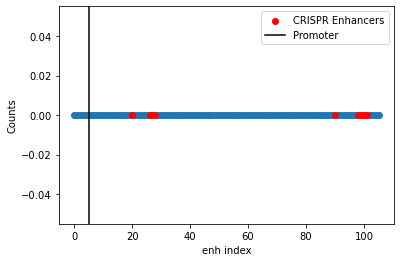

In [21]:
# Plot how often an enhancer is on across different cells

X, Y = [], []
crispr_X, crispr_Y = [], []
enh_counts = matrix.sum(axis=0)
for idx, count in enumerate(enh_counts):
    if idx in crispr_enh_indices:
        crispr_X.append(idx)
        crispr_Y.append(count)
    else:
        X.append(idx)
        Y.append(count)

plt.scatter(X,Y)
plt.scatter(crispr_X,crispr_Y, color='red', label="CRISPR Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [22]:
# create enh accessibility matrix
matrices = []
for enh_idx in range(len(crispr_enhancers)):  
    enh_on_prom_on = promoter_cells[enh_idx].sum()
    enh_off_prom_on = len(promoter_cells) - enh_on_prom_on
    enh_on_prom_off = non_promoter_cells[enh_idx].sum()
    enh_off_prom_off = len(non_promoter_cells) - enh_on_prom_off
    enh_matrix = pd.DataFrame(columns=["E_on", "E_off"])
    enh_matrix.loc["P_on"] = {"E_on": enh_on_prom_on, "E_off": enh_off_prom_on}
    enh_matrix.loc["P_off"] = {"E_on": enh_on_prom_off, "E_off": enh_off_prom_off}
#     enh_matrix.loc["E_sum"] = {"E_on": enh_matrix["E_on"].sum(), "E_off": enh_matrix["E_off"].sum()}
#     enh_matrix["P_sum"] = enh_matrix["E_on"] + enh_matrix["E_off"]
    matrices.append(enh_matrix)

In [23]:
from IPython.display import display
def print_matrices(matrices, only_putative=False):
    total_cells = len(matrix)
    for idx, enh_mat in enumerate(matrices):
        if only_putative and idx not in enh_indexes:
            continue
        display(enh_mat)
        ratio_enh_on = enh_mat.loc["P_on",'E_on'] / enh_mat.loc["P_off",'E_on']
        ratio_enh_off = enh_mat.loc["P_on",'E_off'] / enh_mat.loc["P_off",'E_off']
        ratio_prom_on = enh_mat.loc["P_on",'E_on'] / enh_mat.loc["P_on",'E_off']
        ratio_prom_off = enh_mat.loc["P_off",'E_on'] / enh_mat.loc["P_off",'E_off']
        ratio_5 = ratio_enh_on / ratio_enh_off
        ratio_6 = ratio_prom_on / ratio_prom_off
        print(f"enh: {idx}\n")
        print("Frequency of enhancer being on:")
        print("enh is on {:.2f}%".format(100*enh_mat['E_on'].sum() / total_cells))
        print("\t when prom on {:.2f}%".format(100*enh_mat.loc["P_on",'E_on'] / enh_mat.loc["P_on"].sum()))
        print("\t when prom off {:.2f}%".format(100*enh_mat.loc["P_off",'E_on'] / enh_mat.loc["P_off"].sum()))
        print()
        print("Frequency of promoter being on:")
        print("prom is on {:.2f}%".format(100*enh_mat.loc["P_on"].sum() / total_cells))
        print("\t when enh on {:.2f}%".format(100*enh_mat.loc["P_on",'E_on'] / enh_mat["E_on"].sum()))
        print("\t when enh off {:.2f}%".format(100*enh_mat.loc["P_on",'E_off'].sum() / enh_mat["E_off"].sum()))
        print()
        print("Ratios (want high): 1={:.2f}, 3={:.2f}, 5={:.2f}, 6={:.2f}".format(
            ratio_enh_on, ratio_prom_on, ratio_5, ratio_6))
        print("Ratios (want low): 2={:.2f}, 4={:.2f}".format(
            ratio_enh_off, ratio_prom_off))

In [24]:
# print_matrices(matrices, only_putative=True)

In [25]:
# print_matrices(matrices, only_putative=False)

In [26]:
# Plot bayesian probabilities 
def compute_P_p_e(matrix):
    num_e_on = matrix["E_on"].sum()
    return matrix.loc["P_on", "E_on"] / num_e_on

def compute_P_e_p(matrix):
    num_p_on = len(promoter_cells)
    return matrix.loc["P_on", "E_on"] / num_p_on

def compute_P_e(matrix):
    return matrix["E_on"].sum() / TOTAL_CELLS


In [27]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_p_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_p_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(P|E)')
plt.legend()
plt.show()

NameError: name 'enh_indexes' is not defined

In [ ]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx < PROMOTER_IDX:
        continue
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E)')
plt.legend()
plt.show()

In [ ]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e_p(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e_p(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E|P)')
plt.legend()
plt.show()

In [ ]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e_p(enh_mat) / compute_P_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e_p(enh_mat) / compute_P_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E|P) / P(E)')
plt.legend()
plt.show()

In [ ]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e_p(enh_mat) - compute_P_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e_p(enh_mat) - compute_P_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E|P) - P(E)')
plt.legend()
plt.show()

In [ ]:
# Find strong enhancers by looking at strong ones
scores = []
for enh_idx in range(len(enh_df)):
    score = promoter_cells.loc[:,enh_idx].sum()
    scores.append((score, enh_idx))

strong_scores = list(reversed(sorted(scores)))
print(f"num promoter cells: {len(promoter_cells)}")
strong_scores
    

In [ ]:
# Find strong enh by looking at weak ones. Low score => strong
scores = []
for enh_idx in range(len(enh_df)):
    score = non_promoter_cells.loc[:,enh_idx].sum()
    scores.append((score, enh_idx))

weak_scores = list((sorted(scores)))
print(f"num non promoter cells: {len(non_promoter_cells)}")
weak_scores

In [ ]:
def find_idx_of_enh(score_list, enh_idx):
    for i, (score, idx) in enumerate(score_list):
        if idx == enh_idx:
            return i

In [ ]:
for i in range(10):
    enh_idx = strong_scores[i][1]
    print(enh_idx, find_idx_of_enh(strong_scores, enh_idx), find_idx_of_enh(weak_scores, enh_idx))

In [ ]:
# How often is at least 1 putative enh active when promoter is on?
enh_counts = promoter_cells.loc[:, enh_indexes].sum(axis=1)
num_cells = promoter_cells[enh_counts > 0]
print(len(num_cells)/len(promoter_cells))

In [ ]:
# What is the distribution of how many putative enhancers are on for promoter cells?
import matplotlib.pyplot as plt
plt.hist(enh_counts, color='b', edgecolor='black', bins=6, density=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of a Distribution')

In [ ]:
# What is the distribution for how many cells are promoters based on # of putative enh turned on?
matrix["num_put_enh"] = matrix.loc[:,enh_indexes].sum(axis=1)
promoter_cells = matrix[matrix.loc[:, promoter_idx] == 1]
non_promoter_cells = matrix[matrix.loc[:, promoter_idx] == 0]

In [ ]:
data = []
for num_indexes in range(len(enh_indexes)):
    prom_count = (promoter_cells.loc[:, "num_put_enh"] == num_indexes).sum()
    non_prom_count = (non_promoter_cells.loc[:, "num_put_enh"] == num_indexes).sum()
    data.append((num_indexes, prom_count / (prom_count + non_prom_count)))
x, y = zip(*data)
plt.bar(x,y)
plt.xlabel('Num Putative Enhancers')
plt.ylabel('Perecentage that are promoters')
print(data)

In [ ]:
# When enh 155, why doesn't it cause promoters to be active?
# Are there additional enhancers that it works well with? Activation threshold?
# Let's see what putative enh it tends to pair with when promoter is active
promoter_cells[promoter_cells[155]==1].loc[:,enh_indexes+["num_put_enh"]][:30]

In [ ]:
# When enh 155, why doesn't it cause promoters to be active?
# Are there additional enhancers that it works well with? Activation threshold?
# Let's see what putative enh it tends to pair with when promoter is active
non_promoter_cells[non_promoter_cells[155]==1].loc[:,enh_indexes+["num_put_enh"]][:30]

In [ ]:
# When enh 155 is on, how often is promoter on? (both on / all enh 155 on)
# When enh 155 is off, how often is promoter off? (both off / all enh 155 off)
# How do those values differ from the average of promoter on and off rates?
enh_idx = 155
promoter_on_pct = len(promoter_cells) / len(matrix)
promoter_off_pct = len(non_promoter_cells) / len(matrix)
print("Promoter on/off pct", promoter_on_pct, promoter_off_pct)

enh_155_on = matrix[enh_idx].sum()
on_on_count = (promoter_cells[enh_idx] == 1).sum() / enh_155_on
enh_155_off = len(matrix) - enh_155_on
off_off_count = (non_promoter_cells[enh_idx]==0).sum() / enh_155_off
print("Enh/Prom on/off pct", on_on_count, off_off_count)

In [ ]:
prom_enh_counts = promoter_cells[enh_df.index].sum(axis=1)
print(prom_enh_counts.mean(), prom_enh_counts.std(), prom_enh_counts.median())

In [ ]:
prom_enh_counts = non_promoter_cells[enh_df.index].sum(axis=1)
print(prom_enh_counts.mean(), prom_enh_counts.std(), prom_enh_counts.median())

In [ ]:
genes = tss_df[tss_df["chrom"] == CHROM_NUM]["name"].unique()

In [ ]:
crispr_df[(crispr_df["measuredGeneSymbol"].isin(genes)) & crispr_df["Regulated"]].groupby("measuredGeneSymbol").size()

In [ ]:
len(matrix)

In [ ]:
crispr_df = crispr_df.rename(columns={"chromStart": "start", "chromEnd": "end"})

In [ ]:
crispr_enh_df = crispr_df[["chrom", "start", "end"]].drop_duplicates().reset_index(drop=True)

In [ ]:
overlap_df = bf.overlap(crispr_enh_df, atac_df, how="inner", return_index=True)

In [ ]:
for barcode, df in overlap_df.groupby("barcode_"):
    print(barcode)
    print(df["index"].unique())
    break

In [ ]:
start = time.time()
m = pd.DataFrame(0, index=overlap_df["barcode_"].unique(), columns=range(overlap_df["index"].max()+1))
for barcode, df in overlap_df.groupby("barcode_"):
    enh_indices = df["index"]
    matrix.loc[barcode] = {idx: 1 for idx in enh_indices}

m = matrix.fillna(0).astype(int)
print(time.time() - start)

In [ ]:
matrix